In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyeit.mesh as mesh
import pyeit.eit.jac as jac
from pyeit.eit.utils import eit_scan_lines
from pyeit.eit.fem import Forward
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from tqdm import tqdm
import os
import glob
import math
import requests
import pandas as pd
import seaborn as sns
from src.util import createTrajectory, plot_mesh_permarray

In [2]:
n_el = 16  
mesh_obj = mesh.create(n_el, h0=0.05)

def possible_positions():
    area_radius = 1
    grid_resolution = 0.0175
    plotting = False
    
    x = np.arange(-area_radius, area_radius + grid_resolution, grid_resolution)
    y = np.arange(-area_radius, area_radius + grid_resolution, grid_resolution)
    xx, yy = np.meshgrid(x, y)
    
    mask = xx**2 + yy**2 <= area_radius**2
    grid_points = np.c_[xx[mask], yy[mask]]  
    
    random_index = np.random.choice(len(grid_points))
    center = grid_points[random_index]

    if plotting:
        fig, ax = plt.subplots(figsize=(8, 8))
        circle = plt.Circle((0, 0), area_radius, color='blue', fill=False, linestyle='--', linewidth=1.5)
        ax.add_artist(circle)
        ax.scatter(grid_points[:, 0], grid_points[:, 1], color='red', s=1, label='Grid Points')  # Kleinere Punkte
        ax.scatter(center[0], center[1], color='green', s=50, label='Selected Center', zorder=5)
        ax.set_xlim(-area_radius - 0.1, area_radius + 0.1)
        ax.set_ylim(-area_radius - 0.1, area_radius + 0.1)
        ax.set_aspect('equal', adjustable='box')
        ax.set_title('Uniform Grid Points on Circle', fontsize=14)
        ax.set_xlabel('x-coordinate')
        ax.set_ylabel('y-coordinate')
        ax.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    return center

def generate_training_data_batch(batch_size, added_noise):
    gamma_list = []
    possible_radii = [0.1, 0.15, 0.2]
    
    for idx in range(batch_size):  
        r = np.random.choice(possible_radii)
        center = possible_positions()

        anomaly = PyEITAnomaly_Circle(center=center, r=r, perm=10)
        anomaly_mesh = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)

        gamma = anomaly_mesh.perm
        if added_noise:
            gamma = gamma + np.random.normal(
                scale=0.5, size=mesh_obj.perm_array.shape[0]
            )

        gamma_list.append(gamma)
    
    gamma_array = np.array(gamma_list)
    return gamma_array

def generate_full_training_data(Nsamples, batch_size, added_noise):
    num_batches = Nsamples // batch_size
    remaining_samples = Nsamples % batch_size
    
    gamma_full = [] 

    for batch_idx in tqdm(range(num_batches), desc="Generating training data"):
        gamma_batch = generate_training_data_batch(batch_size, added_noise)
        gamma_full.append(gamma_batch)

    if remaining_samples > 0:
        gamma_batch = generate_training_data_batch(remaining_samples, added_noise)
        gamma_full.append(gamma_batch)

    gamma_full = np.vstack(gamma_full)
    return gamma_full

In [3]:
def createGamma(traj, r_path, r_path_variations, bound, num_points):
    gamma_list = []
    center_pos = createTrajectory(traj, r_path, r_path_variations, bound, num_points)

    r = 0.2
    for center in center_pos:
        anomaly = PyEITAnomaly_Circle(center, r=r, perm=10)
        anomaly_mesh = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
        gamma = anomaly_mesh.perm
        gamma_list.append(gamma)

    gamma_array = np.array(gamma_list)
    
    return gamma_array

In [4]:
def center_of_perm(gamma, plot=True):
    """Calculate the center of permittivity

    """
    pts = mesh_obj.element
    tri = mesh_obj.node
    perm = gamma.copy()
    
    # Berechne die Dreiecks-Zentren
    tri_centers = np.mean(tri[pts], axis=1)
    
    # Suche Positionen mit erhöhter Permittivität
    perm_min = 0.5
    indices = np.where(perm > perm_min)[0]
    coords = tri_centers[indices]

    # Berechne die Mittelwerte der Koordinaten
    x = round(np.mean(coords[:, 0]), 2)
    y = round(np.mean(coords[:, 1]), 2)
    print('x:', x, 'y:', y)
    
    if plot:
        plt.figure(figsize=(5, 5))
        plt.grid()
        plt.xlim((-1, 1))
        plt.ylim((-1, 1))
        plt.scatter(tri_centers[:, 0], tri_centers[:, 1], color='grey', label="Mesh Centers")
        plt.scatter(coords[:, 0], coords[:, 1], color='orange', label="Elevated Permittivity")
        plt.scatter(x, y, color='red', label="Permittivity Center", zorder=5)
        plt.legend()
        plt.show()
    
    return x, y


def evaluation_of_precision(gamma1, gamma2, plot=True):
    """Calculates deviation of perm center and reconstructed perm space

    delta_x : float
        permittivity x-deviation

    delta_y : float
        permittivity y-deviation

    delta_perm: int
        number of average permittivity deviations
    """
    pts = mesh_obj.element
    tri = mesh_obj.node

    # Calculate triangle centers
    tri_centers = np.mean(tri[pts], axis=1)

    # Ground truth (gamma1)
    perm_min = 0.5  # Threshold for elevated permittivity
    indices1 = np.where(gamma1 > perm_min)[0]
    coords1 = tri_centers[indices1]
    x1 = round(np.mean(coords1[:, 0]), 3)
    y1 = round(np.mean(coords1[:, 1]), 3)

    # Reconstruction (gamma2)
    indices2 = np.where(gamma2 > perm_min)[0]
    coords2 = tri_centers[indices2]
    x2 = round(np.mean(coords2[:, 0]), 3)
    y2 = round(np.mean(coords2[:, 1]), 3)

    # Calculate deviations
    delta_x = x1 - x2
    delta_y = y1 - y2
    delta_perm = len(coords1) - len(coords2)

    if plot:
        print(f'Ground Truth Center: x={x1}, y={y1}')
        print(f'Reconstructed Center: x={x2}, y={y2}')
        print(f"Δx: {delta_x}, Δy: {delta_y}")
        print(f"ΔPerm: {delta_perm}")

        plt.figure(figsize=(5, 5))
        plt.grid()
        plt.xlim((-1.1, 1.1))
        plt.ylim((-1.1, 1.1))
        plt.scatter(tri_centers[:, 0], tri_centers[:, 1], label='Mesh Centers', alpha=0.4, s=10)
        plt.scatter(coords1[:, 0], coords1[:, 1], color='green', label='Ground Truth')
        plt.scatter(coords2[:, 0], coords2[:, 1], color='orange', label='Reconstruction')
        plt.scatter(x1, y1, marker='x', color='blue', s=50, label='Ground Truth Center')
        plt.scatter(x2, y2, color='red', s=50, label='Reconstructed Center')
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

    return delta_x, delta_y, delta_perm


def plot_deviations_x_y(data_dict, save=False, fpath='', fname='x_y_deviation.pdf'):
    """
    Plot the x,y-deviation using a kernel density estimation (KDE) plot.
    
    Parameters
    ----------
    data_dict : dict
        Dictionary containing the deviation data with keys:
        - 'x-Abweichung': array-like, x-axis deviations
        - 'y-Abweichung': array-like, y-axis deviations
        - 'Perm': array-like, permutation values (optional)
    save : bool, optional
        Whether to save the plot to file (default: False)
    fpath : str, optional
        File path for saving the plot (default: '')
    fname : str, optional
        Filename for saving the plot (default: 'x_y_deviation.pdf')
    
    Returns
    -------
    g : seaborn.JointGrid
        The generated joint plot object
    """
    # Set style parameters
    plt.rcParams.update({'font.family': 'Serif'})
    sns.set(font_scale=1.5, font='Serif')
    
    # Create DataFrame ensuring data is properly structured
    df = pd.DataFrame({
        'x-Abweichung': np.asarray(data_dict['x-Abweichung']).flatten(),
        'y-Abweichung': np.asarray(data_dict['y-Abweichung']).flatten()
    })
    
    # Create figure
    plt.figure(figsize=(7, 7))
    
    # Set plot limits
    plot_limits = [-1, 1]
    
    # Create joint plot
    g = sns.jointplot(
        data=df,
        x='x-Abweichung',
        y='y-Abweichung',
        kind='kde',
        xlim=plot_limits,
        ylim=plot_limits
    )
    
    # Add filled contour plot
    g.plot_joint(sns.kdeplot, fill=True, levels=50, cmap="viridis")
    
    # Calculate and print average deviations
    x_mean = np.mean(data_dict['x-Abweichung'])
    y_mean = np.mean(data_dict['y-Abweichung'])
    print(f"Durchschnittliche x-Abw: {x_mean:.2f}")
    print(f"Durchschnittliche y-Abw: {y_mean:.2f}")
    
    # Save plot if requested
    if save:
        plt.tight_layout()
        full_path = fpath + fname
        g.savefig(full_path)
        print(f"Plot saved to: {full_path}")


def plot_deviations_perm(Dict, save=False, fpath='', fname='perm_deviation.pdf', binwidth=10):
    """Plot the x,y-deviation

    Parameters
    ----------
    Dict : dictionary
        {'x-Abweichung': X, 'y-Abweichung': Y, 'Perm':Perm}

    save : Bool
        save plot

    fpath : string
        filepath

    fname : string
        name of the saved plot

    binwidth : int
        seaborn binwidth plot configuration

    """
    plt.rcParams.update({'font.family': 'Serif'})

    df = pd.DataFrame.from_dict(Dict)
    plt.figure(figsize=(7, 7))
    plt.autoscale()
    sns.set(font_scale=2, font='Serif')
    p = sns.histplot(data=df, x='Perm', binwidth=binwidth,
                     kde=True)  # , kde=True
    # p.invert_xaxis()
    p.set_xlabel("Abweichende Elemente")
    p.set_ylabel("Anzahl")
    fig = p.get_figure()
    print('Mittlere Perm-Abweichung:', round(np.mean(Dict['Perm'])), '[FE]')
    st_fe = 2807
    print('Prozentuale Abweichung:', round(
        (np.mean(Dict['Perm'])/st_fe)*100, 2), '[%]')
    if save:
        plt.tight_layout()
        plt.savefig(fpath+fname)


Nsamples = 10
batch_size = 10000 
added_noise = True

gamma_array = generate_full_training_data(Nsamples, batch_size, added_noise)
print(f"Generated {gamma_array.shape[0]} samples")
gamma_array = gamma_array/ 15

In [5]:
Nsteps = 100
r_path = 0.5 
traj = "Kreis"
gamma1 = createGamma(traj, r_path, r_path_variations = False, bound = 0.5, num_points = Nsteps)
gamma1 = gamma1/15
traj = "Spirale"
gamma2 = createGamma(traj, r_path, r_path_variations = False, bound = 0.1, num_points = Nsteps)
gamma2 = gamma2/15

In [6]:
gamma1.shape

(100, 2821)

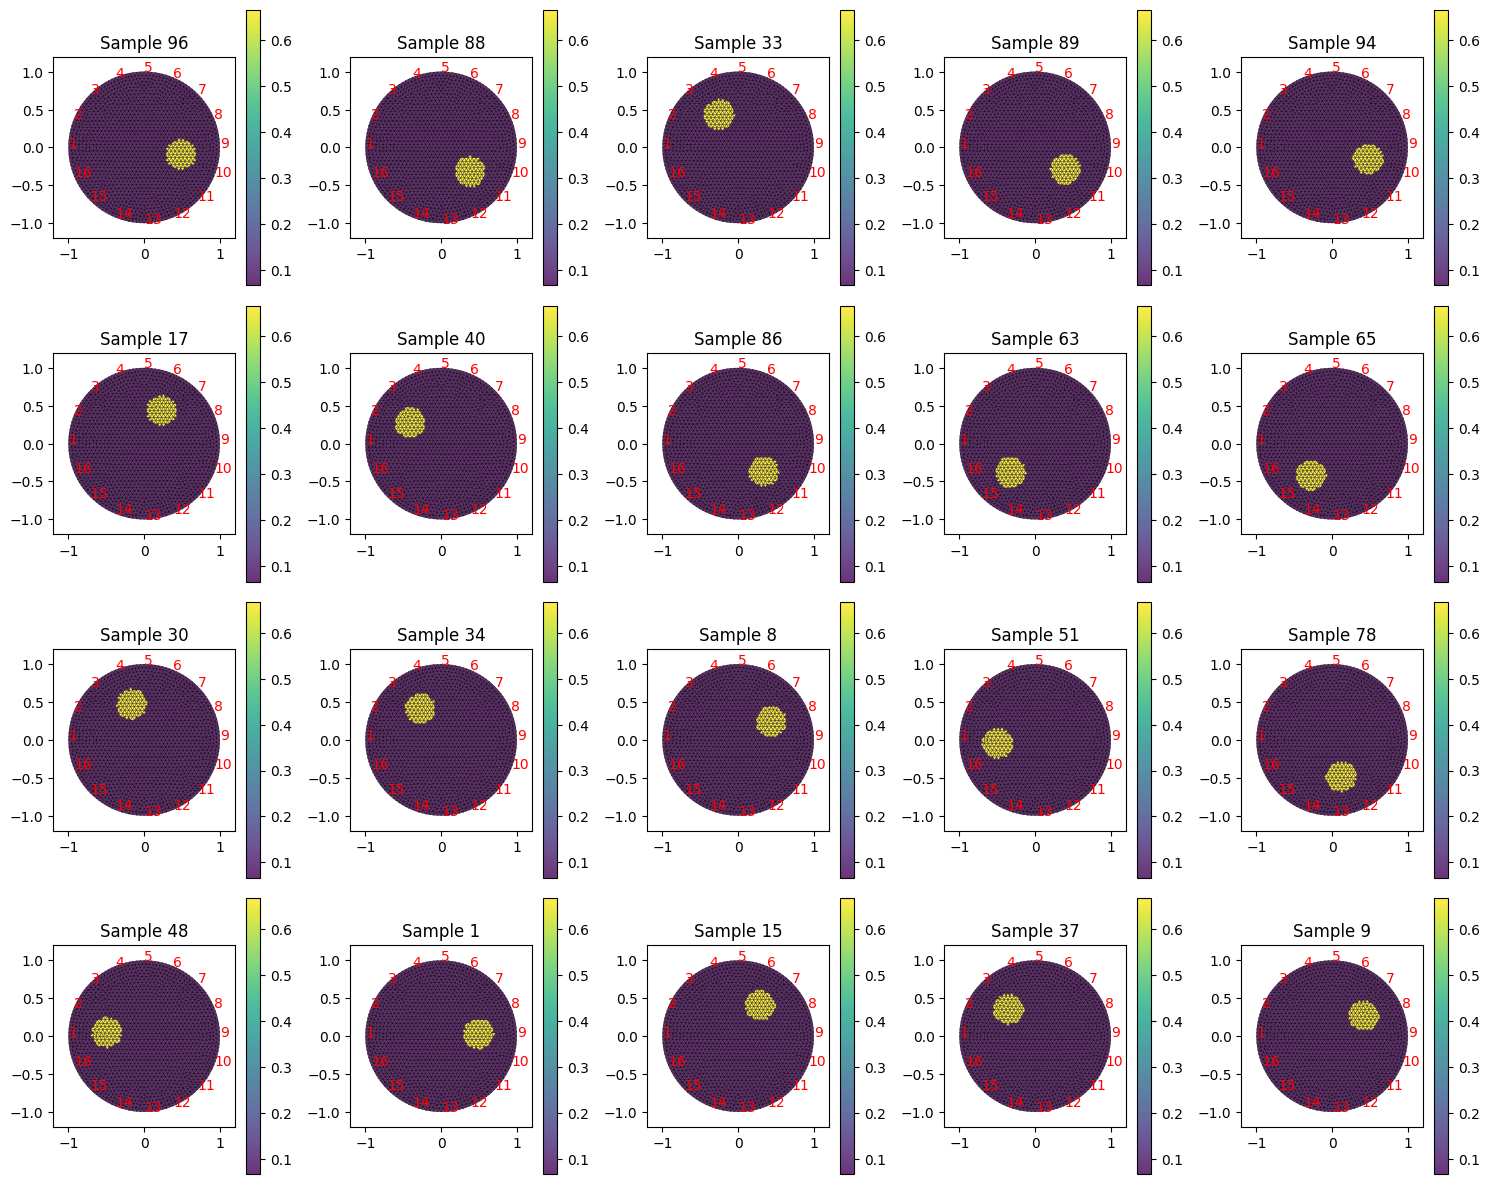

In [7]:
def plot_random_samples(mesh_obj, gamma_array, num_samples=20):
    """
    Plottet zufällig ausgewählte Permittivitätskarten aus gamma_array.

    Parameters:
    - mesh_obj: Das Mesh-Objekt, das die Geometrie repräsentiert.
    - gamma_array: Ein Array mit den Permittivitätswerten (jeder Eintrag repräsentiert einen Zustand).
    - num_samples: Anzahl der zufällig zu plottenden Permittivitätskarten (default: 20).
    """
    if num_samples > len(gamma_array):
        print(f"Warnung: Es gibt nur {len(gamma_array)} Einträge. Alle werden geplottet.")
        num_samples = len(gamma_array)
    
    # Zufällige Indizes auswählen
    random_indices = np.random.choice(len(gamma_array), size=num_samples, replace=False)
    
    # Subplots erstellen
    cols = 5
    rows = int(np.ceil(num_samples / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()
    
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        plot_mesh_permarray(mesh_obj, gamma_array[idx, :], ax=ax, title=f"Sample {idx}")
    
    # Überflüssige Subplots entfernen
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_random_samples(mesh_obj, gamma1, num_samples=20)

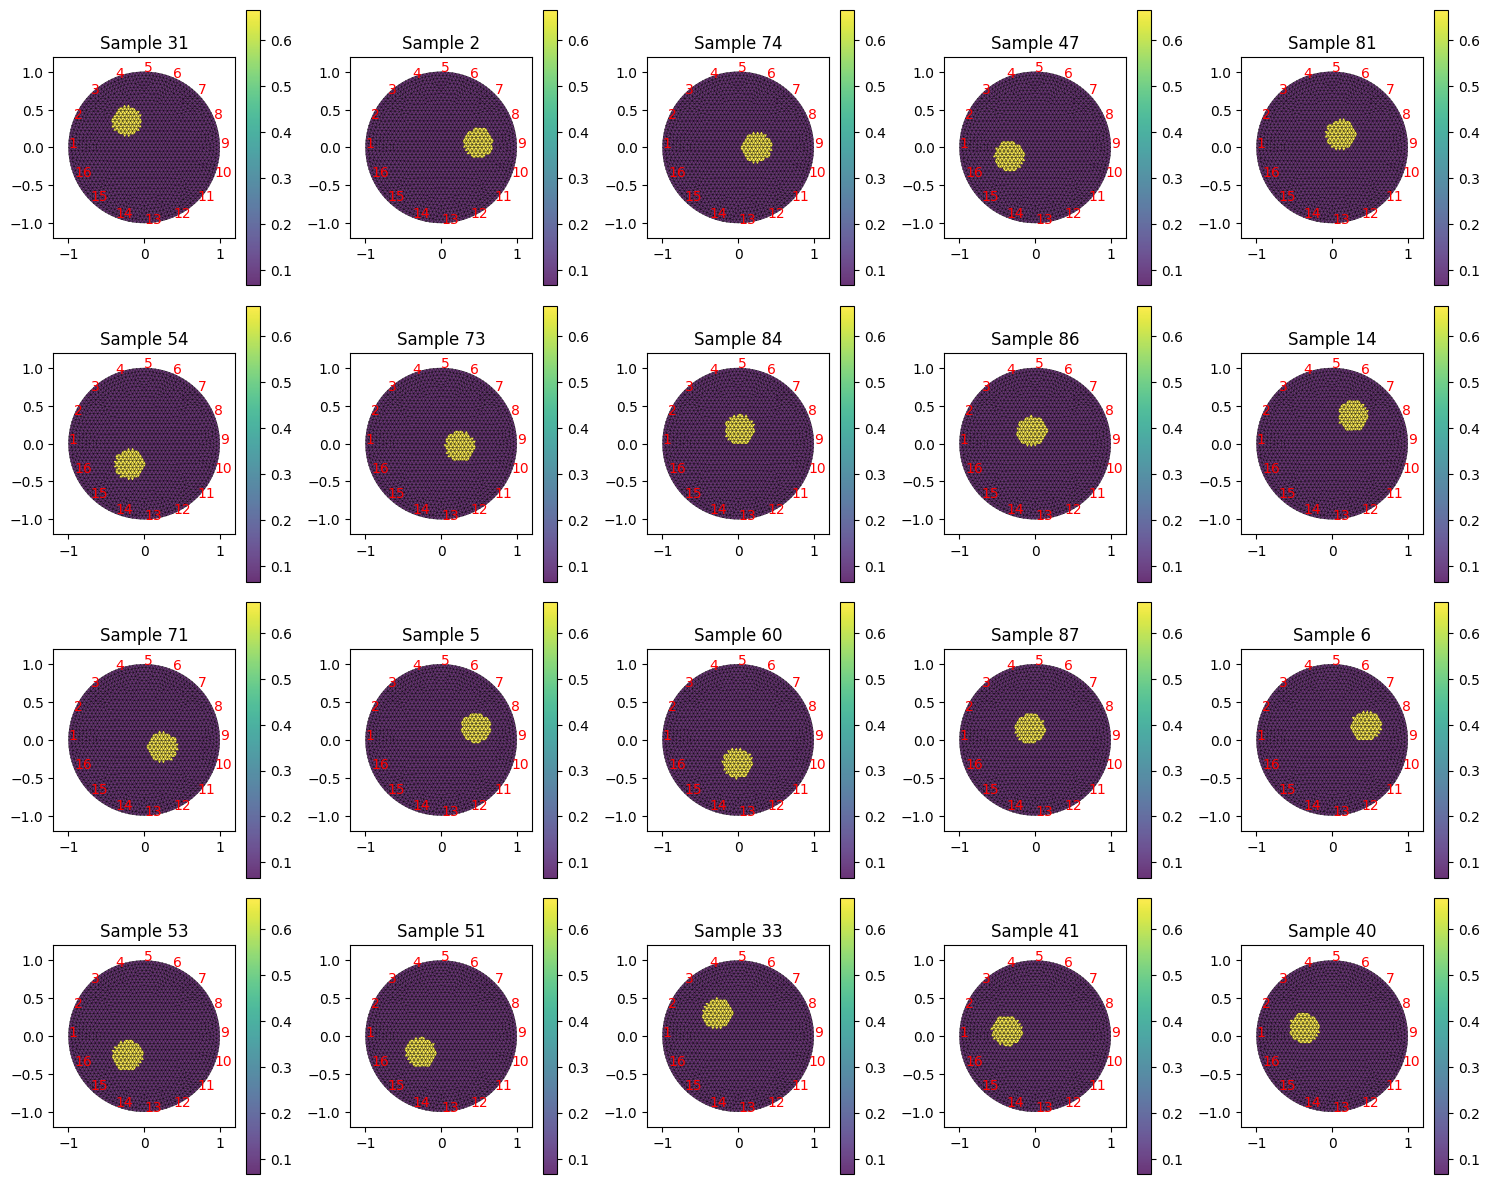

In [8]:
plot_random_samples(mesh_obj, gamma2, num_samples=20)

In [9]:
# Letzten 10 Samples von gamma1 und gamma2 extrahieren
gamma1_last_10 = gamma1[-10:]
gamma2_last_10 = gamma2[-10:]

for gamma1 in gamma1_last_10:
    center_of_perm(gamma1, plot=False)

for g1, g2 in zip(gamma1_last_10, gamma2_last_10):
    delta_x, delta_y, delta_perm = evaluation_of_precision(g1, g2, plot=True)

#delta_x, delta_y, delta_perm = evaluation_of_precision(gamma1, gamma2, plot=True)

Ground Truth Center: x=0.416, y=-0.269
Reconstructed Center: x=-0.117, y=0.068
Δx: 0.533, Δy: -0.337
ΔPerm: -2


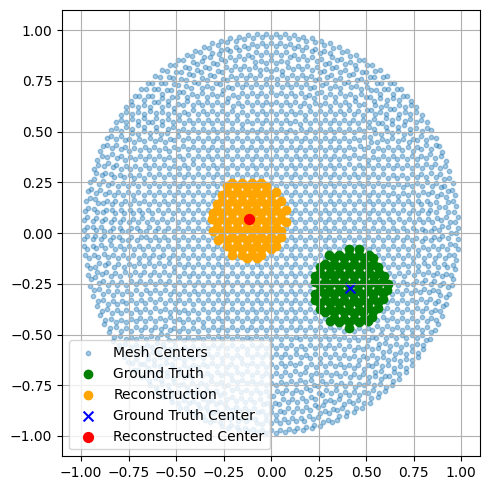

Ground Truth Center: x=0.436, y=-0.242
Reconstructed Center: x=-0.128, y=0.041
Δx: 0.5640000000000001, Δy: -0.283
ΔPerm: -3


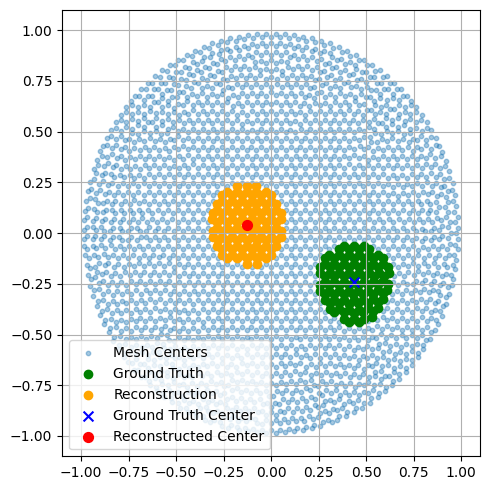

Ground Truth Center: x=0.448, y=-0.214
Reconstructed Center: x=-0.119, y=0.012
Δx: 0.567, Δy: -0.226
ΔPerm: -2


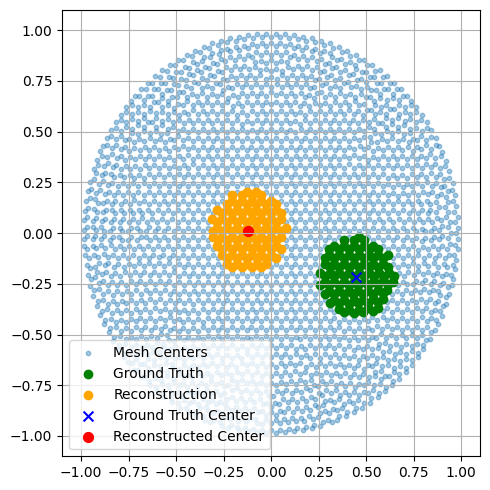

Ground Truth Center: x=0.462, y=-0.186
Reconstructed Center: x=-0.104, y=-0.019
Δx: 0.5660000000000001, Δy: -0.167
ΔPerm: 1


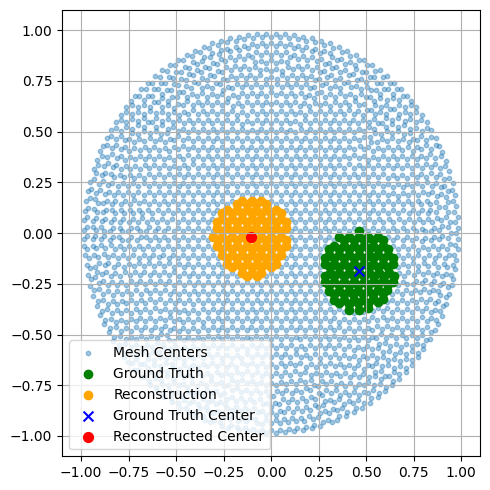

Ground Truth Center: x=0.478, y=-0.156
Reconstructed Center: x=-0.084, y=-0.042
Δx: 0.5619999999999999, Δy: -0.11399999999999999
ΔPerm: 0


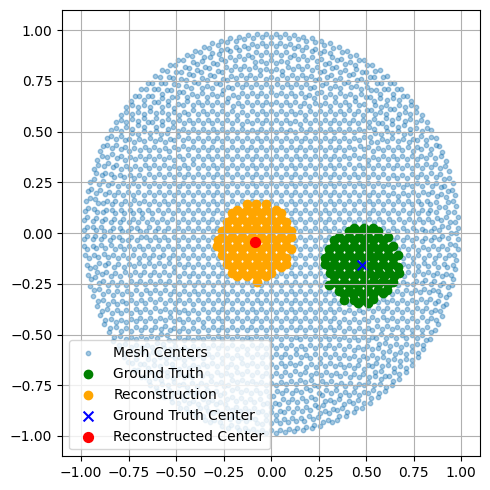

Ground Truth Center: x=0.487, y=-0.122
Reconstructed Center: x=-0.061, y=-0.062
Δx: 0.548, Δy: -0.06
ΔPerm: -1


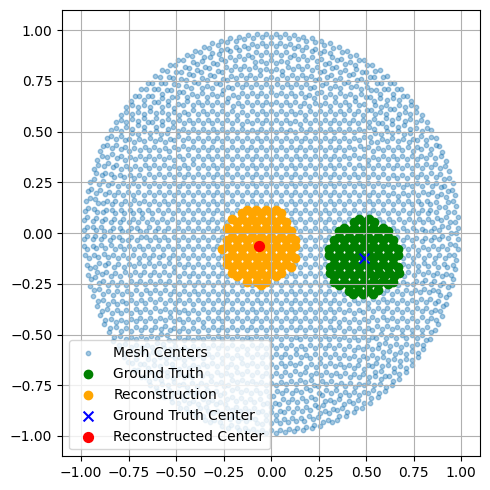

Ground Truth Center: x=0.487, y=-0.093
Reconstructed Center: x=-0.025, y=-0.064
Δx: 0.512, Δy: -0.028999999999999998
ΔPerm: -1


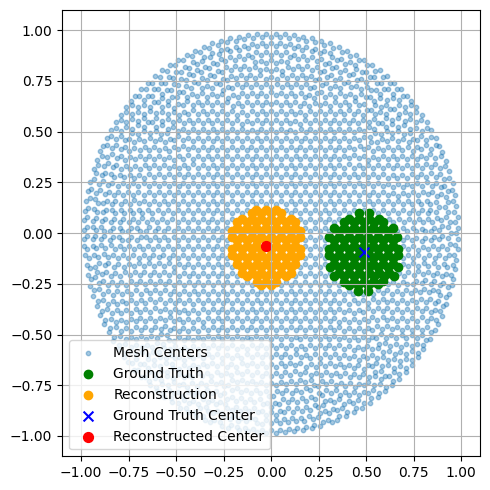

Ground Truth Center: x=0.496, y=-0.065
Reconstructed Center: x=0.0, y=-0.049
Δx: 0.496, Δy: -0.016
ΔPerm: 3


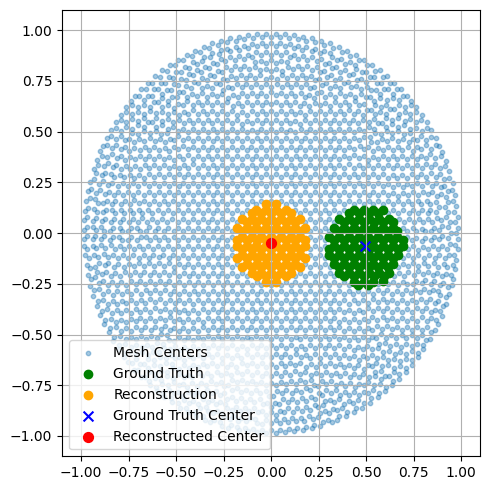

Ground Truth Center: x=0.496, y=-0.029
Reconstructed Center: x=0.015, y=-0.027
Δx: 0.481, Δy: -0.0020000000000000018
ΔPerm: -2


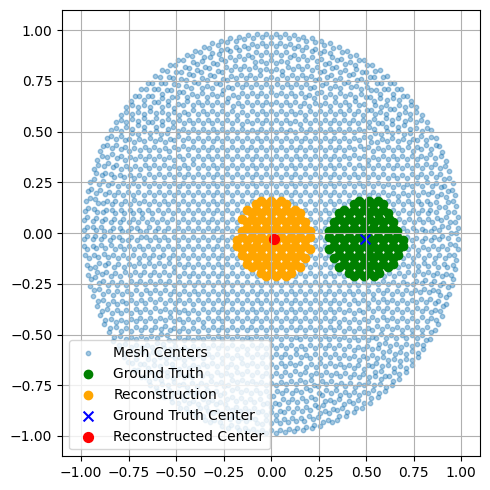

Ground Truth Center: x=0.502, y=-0.001
Reconstructed Center: x=0.0, y=-0.001
Δx: 0.502, Δy: 0.0
ΔPerm: -2


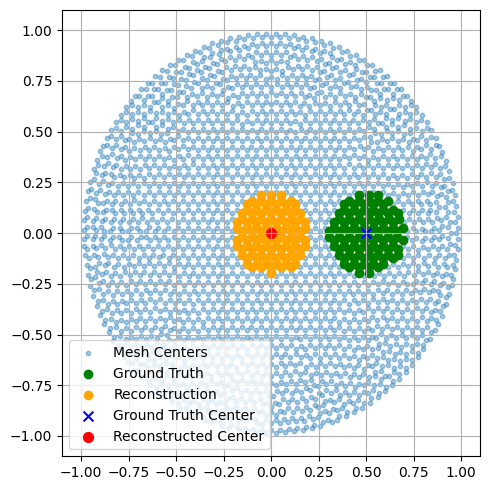

Durchschnittliche x-Abw: 0.53
Durchschnittliche y-Abw: -0.12
Mittlere Perm-Abweichung: -1 [FE]
Prozentuale Abweichung: -0.03 [%]


<Figure size 700x700 with 0 Axes>

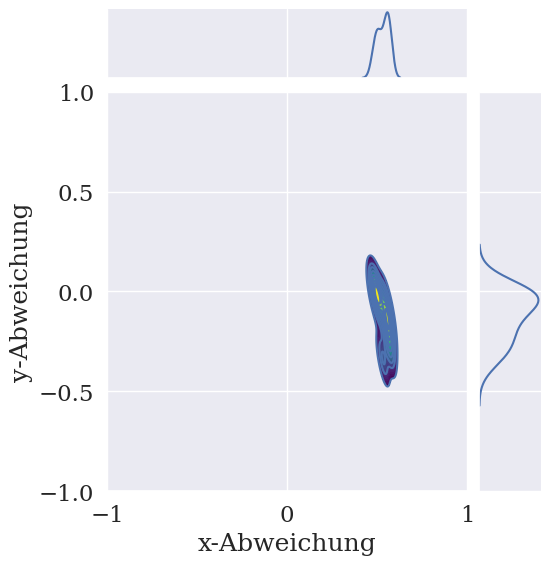

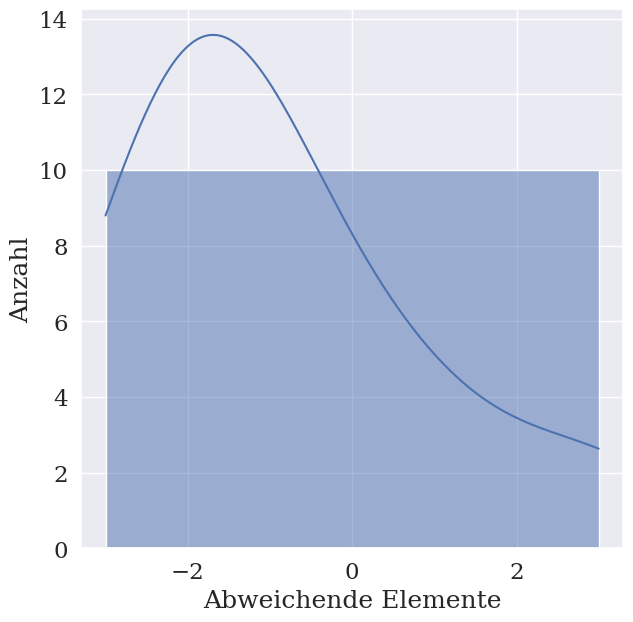

In [10]:
# Dictionary zum Speichern aller Ergebnisse
all_results = {
    'x-Abweichung': [],
    'y-Abweichung': [],
    'Perm': []
}

for gamma1, gamma2 in zip(gamma1_last_10, gamma2_last_10): 
    # Evaluation durchführen
    delta_x, delta_y, delta_perm = evaluation_of_precision(gamma1, gamma2, plot=True)
    
    # Ergebnisse zum Dictionary hinzufügen
    all_results['x-Abweichung'].append(delta_x)
    all_results['y-Abweichung'].append(delta_y)
    all_results['Perm'].append(delta_perm)

plot_deviations_x_y(all_results)
plot_deviations_perm(all_results)